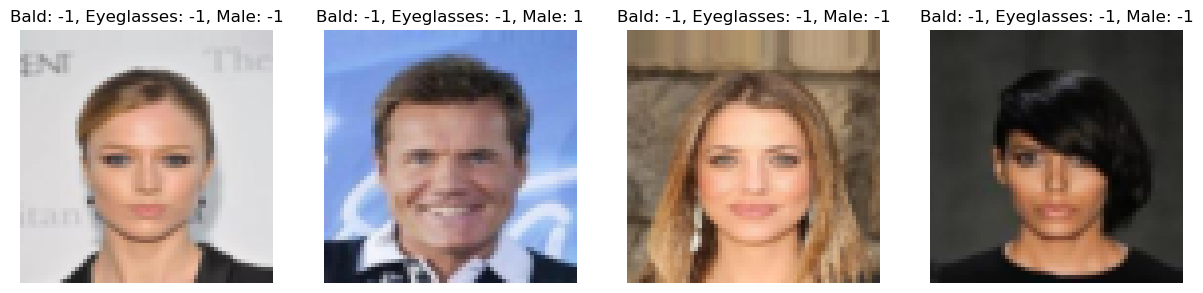

In [81]:
#Loading the dataset

import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
import torch.optim as optim
from torchvision.utils import save_image

# Load the CSV file with attributes
attributes_file = "C:/Users/H-B-RS-720-02/Documents/DC-Gan file/archive/list_attr_celebaReduceto3.csv"
attributes = pd.read_csv(attributes_file)

# Define the image directory
image_dir = "C:/Users/H-B-RS-720-02/Documents/DC-Gan file/archive/img_align_celeba/img_align_celeba"

# Define a transform to convert the image to tensor
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 64x64
    transforms.ToTensor(),
])

# Function to load and display images with attributes
def display_images_with_attributes(image_names):
    fig, axes = plt.subplots(1, len(image_names), figsize=(15, 5))
    for ax, img_name in zip(axes, image_names):
        # Load image
        img_path = f"{image_dir}/{img_name}"
        img = Image.open(img_path).convert("RGB")
        img_tensor = transform(img)

        # Display image
        ax.imshow(img_tensor.permute(1, 2, 0))
        ax.axis('off')

        # Get attributes
        img_attributes = attributes[attributes['image_id'] == img_name].iloc[:, 1:]
        attr_title = ", ".join([f"{col}: {val}" for col, val in zip(img_attributes.columns, img_attributes.values[0])])
        ax.set_title(attr_title)

    plt.show()

# Display 4 images with their attributes
sample_images = attributes['image_id'].sample(4).tolist()
display_images_with_attributes(sample_images)


In [82]:
print(attributes.columns)


Index(['image_id', 'Bald', 'Eyeglasses', 'Male'], dtype='object')


Pre-Processing 

In [83]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
import pandas as pd

# Define the dataset class
class CelebADataset(Dataset):
    def __init__(self, attributes_file, image_dir, transform=None):
        self.attributes = pd.read_csv(attributes_file)
        self.image_dir = image_dir
        self.transform = transform
        self.image_names = self.attributes['image_id'].tolist()  # Update with the correct column name
        print(f"Loaded {len(self.image_names)} image names.")

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # Check if the image exists
        if not os.path.exists(img_path):
            print(f"Image not found: {img_path}")
            return None, None

        image = Image.open(img_path).convert("RGB")

        attributes = self.attributes.iloc[idx, 1:].values.astype('float32')  # Exclude the image_id column

        if self.transform:
            image = self.transform(image)

        return image, attributes

# Define a simple transformation
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor(),        # Convert the image to a tensor
])

# Create the dataset
dataset = CelebADataset(attributes_file=attributes_file, image_dir=image_dir, transform=simple_transform)

# Define the number of images you want to use for training
num_images = 10000  # Reduce the number for faster testing

# Subset the dataset
subset_indices = np.random.choice(len(dataset), num_images, replace=False)
subset_dataset = Subset(dataset, subset_indices)

# Create the DataLoader with the subset
subset_dataloader = DataLoader(subset_dataset, batch_size=4, shuffle=True, num_workers=0)

# Example of iterating through the subset dataloader
for images, attrs in subset_dataloader:
    if images is not None:
        print(images.shape)  # Should print torch.Size([4, 3, 64, 64])
        print(attrs.shape)   # Should print torch.Size([4, num_attributes])
    break


Loaded 202599 image names.
torch.Size([4, 3, 64, 64])
torch.Size([4, 3])


In [84]:
import torch
import torch.nn as nn

# Define the generator model
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()
        self.init_size = img_shape[1] // 16  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 256 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, img_shape[0], 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 256, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

# Define the discriminator model
import torch.nn.functional as F


import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(img_shape[0], 64, bn=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            *discriminator_block(512, 1024),
            nn.AdaptiveMaxPool2d((4, 4))  # Adaptive max pooling to ensure fixed output size
        )

        # Calculate the size of the output after convolutional layers
        self.adv_layer = self._make_adv_layer()

    def _make_adv_layer(self):
        # Calculate output dimensions after convolutional layers
        ds_size = 1024 * 4 * 4  # Fixed size due to adaptive pooling
        return nn.Sequential(nn.Linear(ds_size, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        return validity

# Parameters
latent_dim = 100
img_shape = (3, 128, 128)

# Initialize models
generator = Generator(latent_dim, img_shape)
discriminator = Discriminator(img_shape)

# Print model summaries
print("Generator Architecture:")
print(generator)
print("\nDiscriminator Architecture:")
print(discriminator)


Generator Architecture:
Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=16384, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode='nearest')
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Upsample(scale_factor=2.0, mode='nearest')
    (10): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
 

In [85]:
import torch.optim as optim
import torch.nn as nn

# Loss function
adversarial_loss = nn.BCELoss()

# Optimizers
lr = 0.0002
beta1 = 0.5
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))


In [ ]:

# Training parameters
n_epochs = 10  # Number of epochs
sample_interval = 100  # Interval for saving generated samples

# Training loop
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(subset_dataloader):

        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1, requires_grad=False)
        fake = torch.zeros(imgs.size(0), 1, requires_grad=False)

        # Configure input
        real_imgs = imgs

        # ---------------------
        #  Train Generator
        # ---------------------
        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = torch.randn(imgs.size(0), latent_dim)

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Loss for real images
        real_loss = adversarial_loss(discriminator(real_imgs), valid)

        # Loss for fake images
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)

        # Total discriminator loss
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # Print the progress
        if i % 10 == 0:
            print(f"Epoch [{epoch}/{n_epochs}] Batch {i}/{len(subset_dataloader)} \
                  Loss D: {d_loss.item()}, loss G: {g_loss.item()}")

        # Save generated samples
        if i % sample_interval == 0:
            save_image(gen_imgs.data, f"C:/Users/H-B-RS-720-02/Documents/DC-Gan file/Outputs/TryTry/{epoch}_{i}.png", normalize=True)

# Note: Ensure you have a folder named 'images' to save generated samples.


Epoch [0/10] Batch 0/2500                   Loss D: 0.692413330078125, loss G: 0.6965304613113403
Epoch [0/10] Batch 10/2500                   Loss D: 0.5746528506278992, loss G: 0.6808652877807617
Epoch [0/10] Batch 20/2500                   Loss D: 0.572219967842102, loss G: 0.6026479601860046
Epoch [0/10] Batch 30/2500                   Loss D: 0.5289284586906433, loss G: 0.4693641662597656
Epoch [0/10] Batch 40/2500                   Loss D: 0.31006544828414917, loss G: 0.9764401316642761
Epoch [0/10] Batch 50/2500                   Loss D: 0.4202996492385864, loss G: 1.096797227859497
Epoch [0/10] Batch 60/2500                   Loss D: 0.25791722536087036, loss G: 1.680634617805481
Epoch [0/10] Batch 70/2500                   Loss D: 0.43427854776382446, loss G: 1.460324764251709
Epoch [0/10] Batch 80/2500                   Loss D: 0.7132778167724609, loss G: 0.6579428911209106
Epoch [0/10] Batch 90/2500                   Loss D: 0.31763094663619995, loss G: 1.3460341691970825
Ep

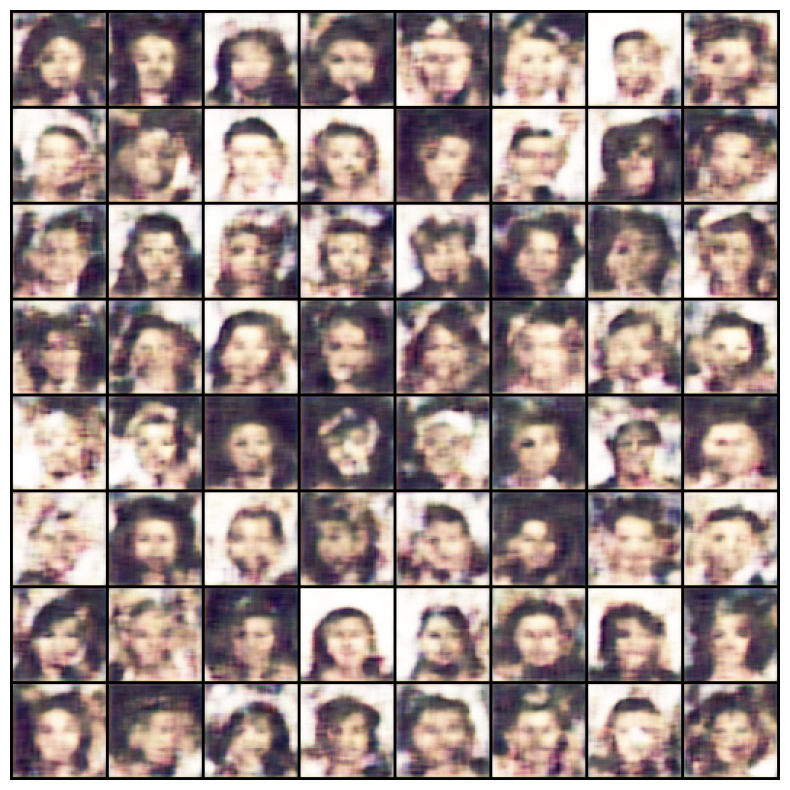

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

# Parameters
latent_dim = 100
num_images = 64  # Number of images to generate

# Sample random noise vectors
z = torch.randn(num_images, latent_dim)

# Generate images using the generator
with torch.no_grad():
    gen_imgs = generator(z).detach().cpu()

# Save the generated images
save_image(gen_imgs.data, "generated_images.png", normalize=True)

# Display the generated images
def display_images(images, nrow=8):
    grid_img = torchvision.utils.make_grid(images, nrow=nrow, normalize=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

# Display the generated images
display_images(gen_imgs)
